In [62]:
!pip install transformers

In [7]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 4.9 MB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 17.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 8.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 17.9 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 6.5 MB/s eta 0:00:00m eta 0:00:010:00:01


In [4]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 4.0 MB/s eta 0:00:000:00:01m eta 0:00:01


In [48]:
import pandas as pd
import transformers
import transformers
from transformers import BertModel, BertTokenizer, TFBertModel, TFBertForSequenceClassification, BertConfig, AdamW, get_linear_schedule_with_warmup
import torch
import re
from transformers import AutoTokenizer
import torch
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
#from pandas_profiling import ProfileReport
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.models import  Sequential


In [2]:
print(torch.__version__)
print(transformers.__version__)

1.13.1+cu117
4.26.1


In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [5]:
df_train.sample(2)

id       keyword location  \
2053  2945        danger   Israel   
1592  2299  cliff%20fall      NaN   

                                                                                                                     text  \
2053  In my experience if you're always angry and critical as a pundit you are in grave danger of going off the rails. 1/   
1592         That sounds like a really bad idea I like Yoenis but I feel like his production could fall off a huge cliff.   

      target  
2053       0  
1592       0

In [6]:
df_train.describe()

id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

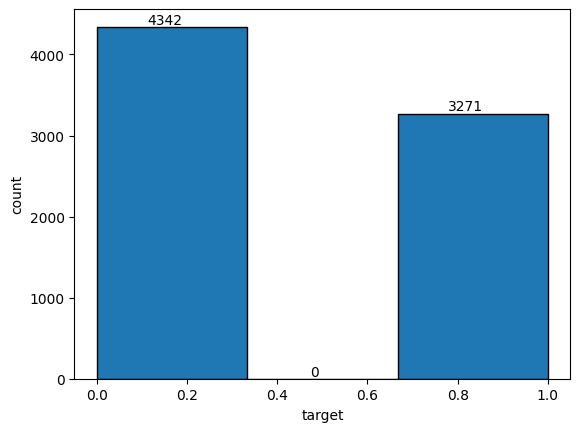

In [7]:
counts, bins, _ = plt.hist(df_train['target'], bins=3, edgecolor='black')

#print(_)
# add text to each bar
for i in range(len(counts)):
   # print(i)
    plt.text(bins[i]+0.15, counts[i]+0.5, int(counts[i]), ha='center', va='bottom')

# set the x and y axis labels
plt.xlabel('target')
plt.ylabel('count')

# display the plot
plt.show()


In [8]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [10]:
profile = ProfileReport(df_train, title="Pandas Profiling Report")
profile.to_notebook_iframe()

NameError: name 'ProfileReport' is not defined

In [11]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
# drop location data
clean_train = df_train.drop(columns="location")
clean_test = df_test.drop(columns="location")

In [13]:
clean_train.sample(10)

id       keyword  \
4304   6111      hellfire   
7313  10467  wild%20fires   
7074  10132      upheaval   
4935   7030        mayhem   
2432   3494      derailed   
6914   9915       trouble   
977    1414    body%20bag   
5359   7648         panic   
358     516          army   
2119   3045         death   

                                                                                                                                             text  \
4304                           The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'   
7313                                                                                                         These wild fires out west are crazy.   
7074                                          Acquire your postexistence straight a elevation in addition to upheaval ideas yet perquisite: bRZjc   
4935  IÛªve seen lots ask about this MT @JMCwrites #Pitchwars I asked for magic realism but not fantasy. What's the diff? http://t.co/64xR9LtNOH   
2432                                                                     .@unsuckdcmetro Is the train half-derailed or half-railed? #deepthoughts   
6914                                 A man a woman Romance &amp; South Afrikaan Trouble - on # sale PreOrder #theBargain - http://t.co/UMl5jZTmcB   
977            å_? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/zujwUiomb3 http://t.co/YklTFj1FnC   
5359                                                                      @brokenscnecal I just though about panic! at the disco when I said that   
358                                       One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1392   
2119                                                                                                 Y'all PUSSSSSSSSSY AND SHOOOK TO DEATH OF ME   

      target  
4304       0  
7313       1  
7074       0  
4935       0  
2432       1  
6914       0  
977        0  
5359       0  
358        1  
2119       0

In [14]:
clean_train.shape

(7613, 4)

222 unique words in the keyword column for train data.


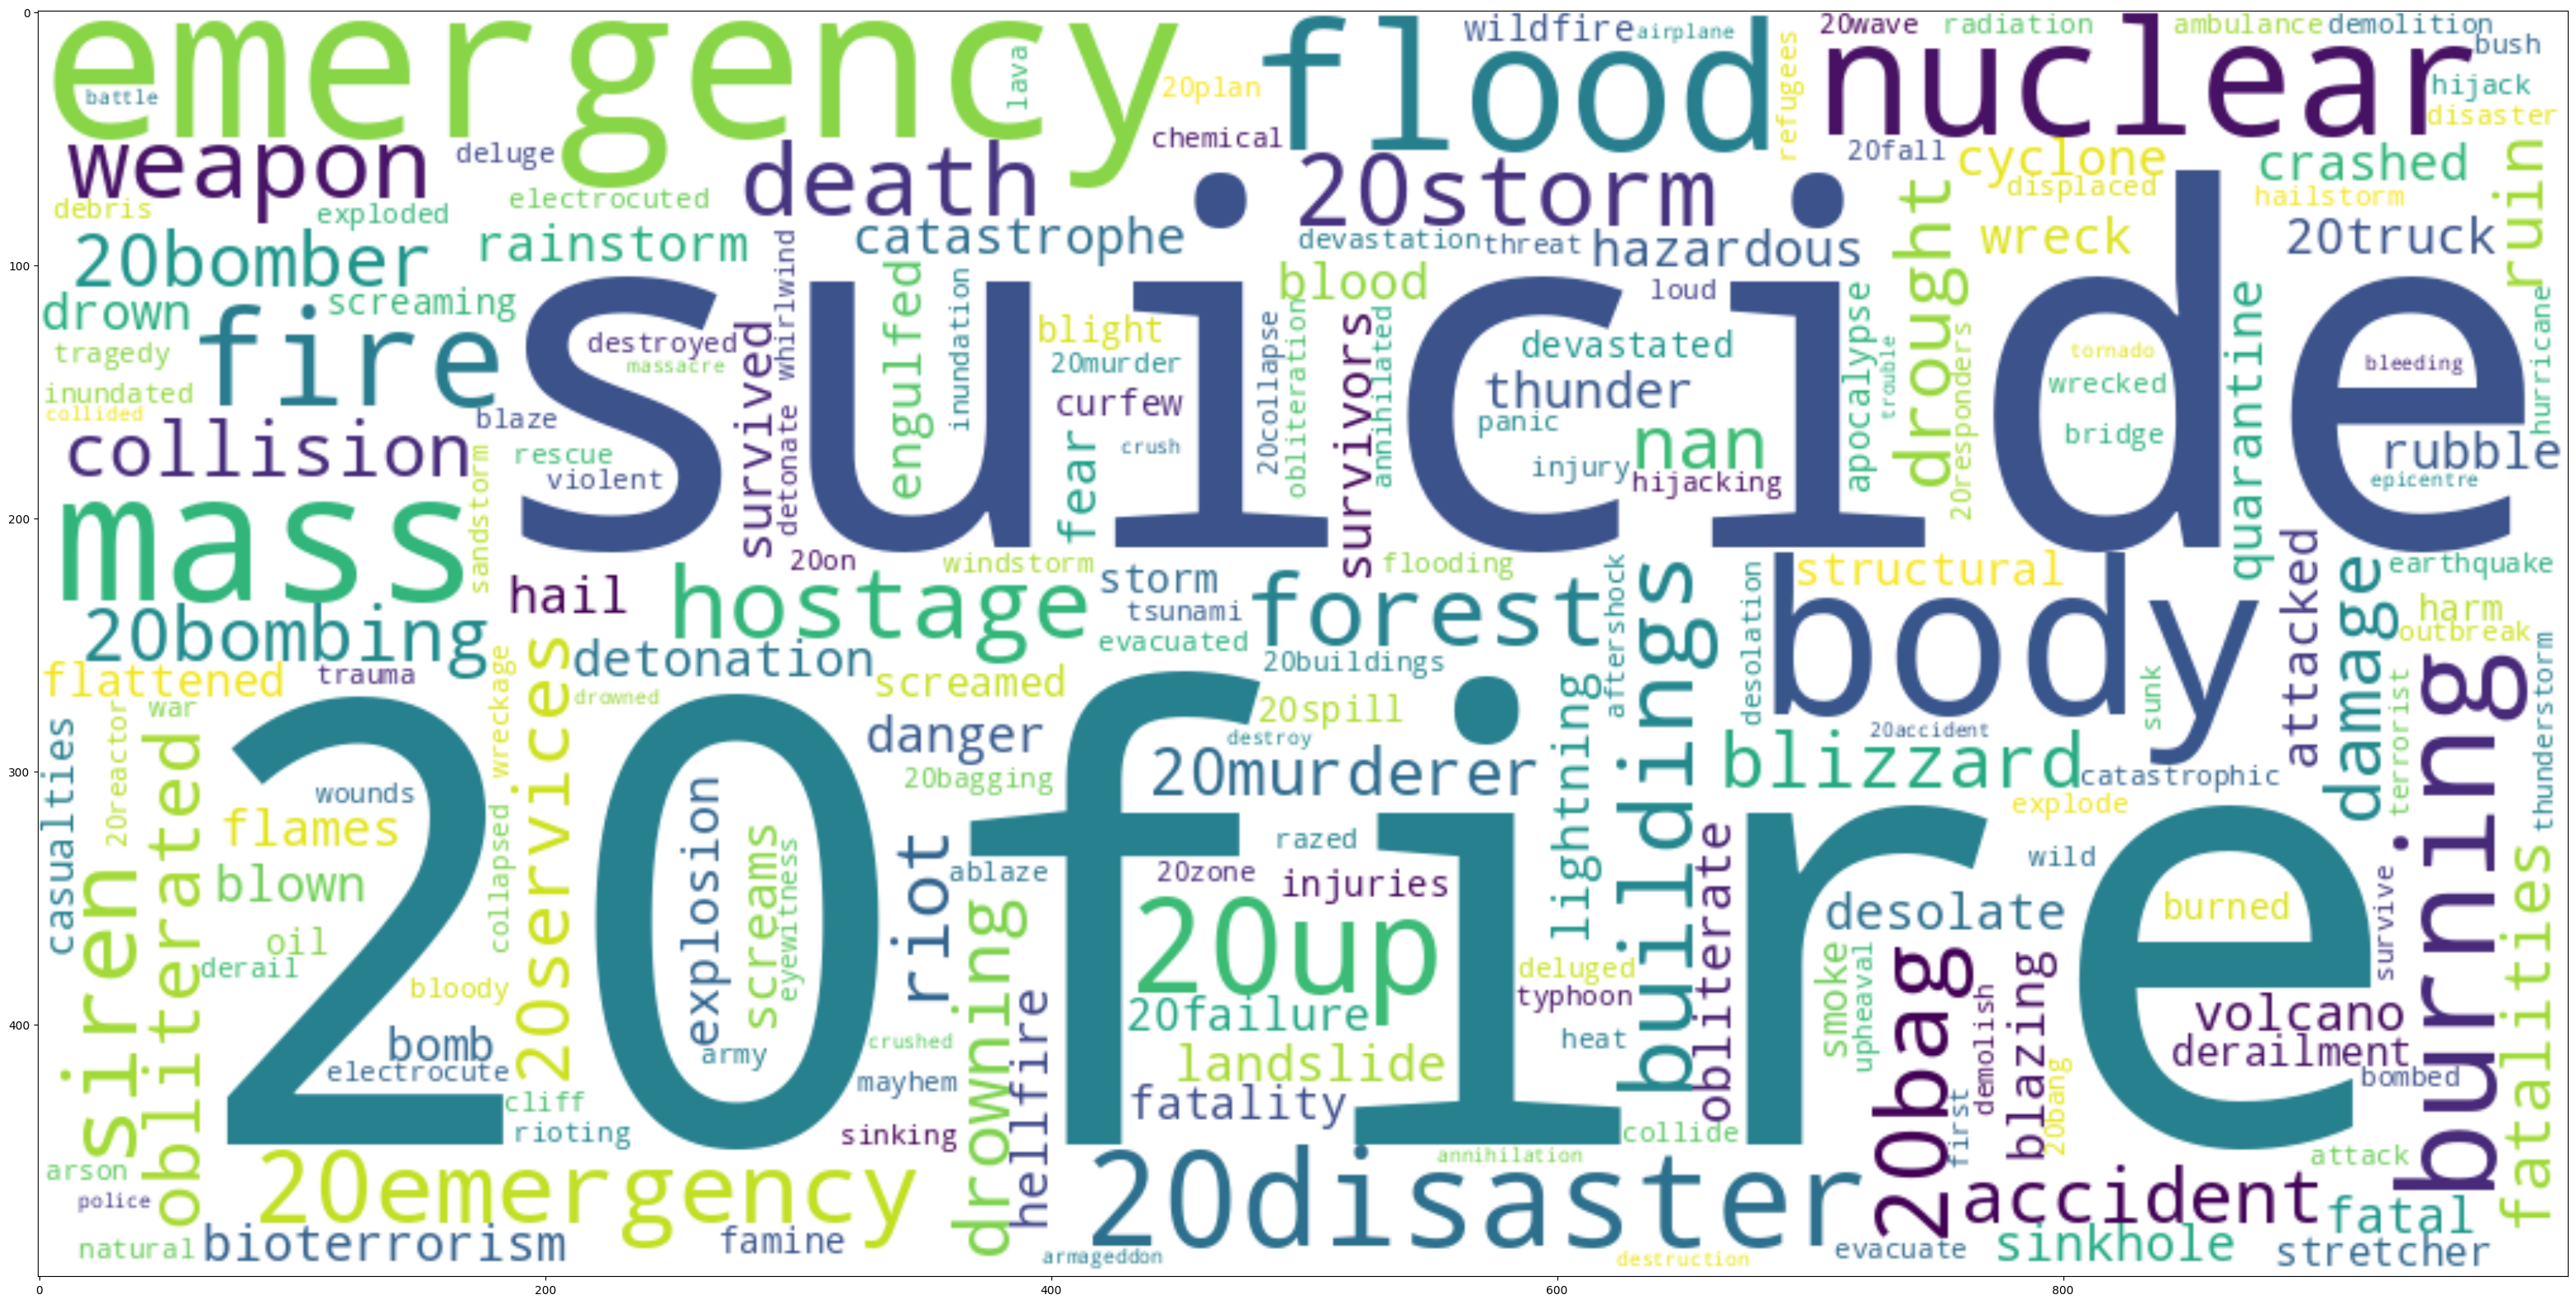

In [15]:
text = " ".join(set(word for word in clean_train['keyword'].astype(str)))
print(f"{len(set(text.split()))} unique words in the keyword column for train data.")
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=1000, height=500).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

222 unique words in the keyword column for Test data.


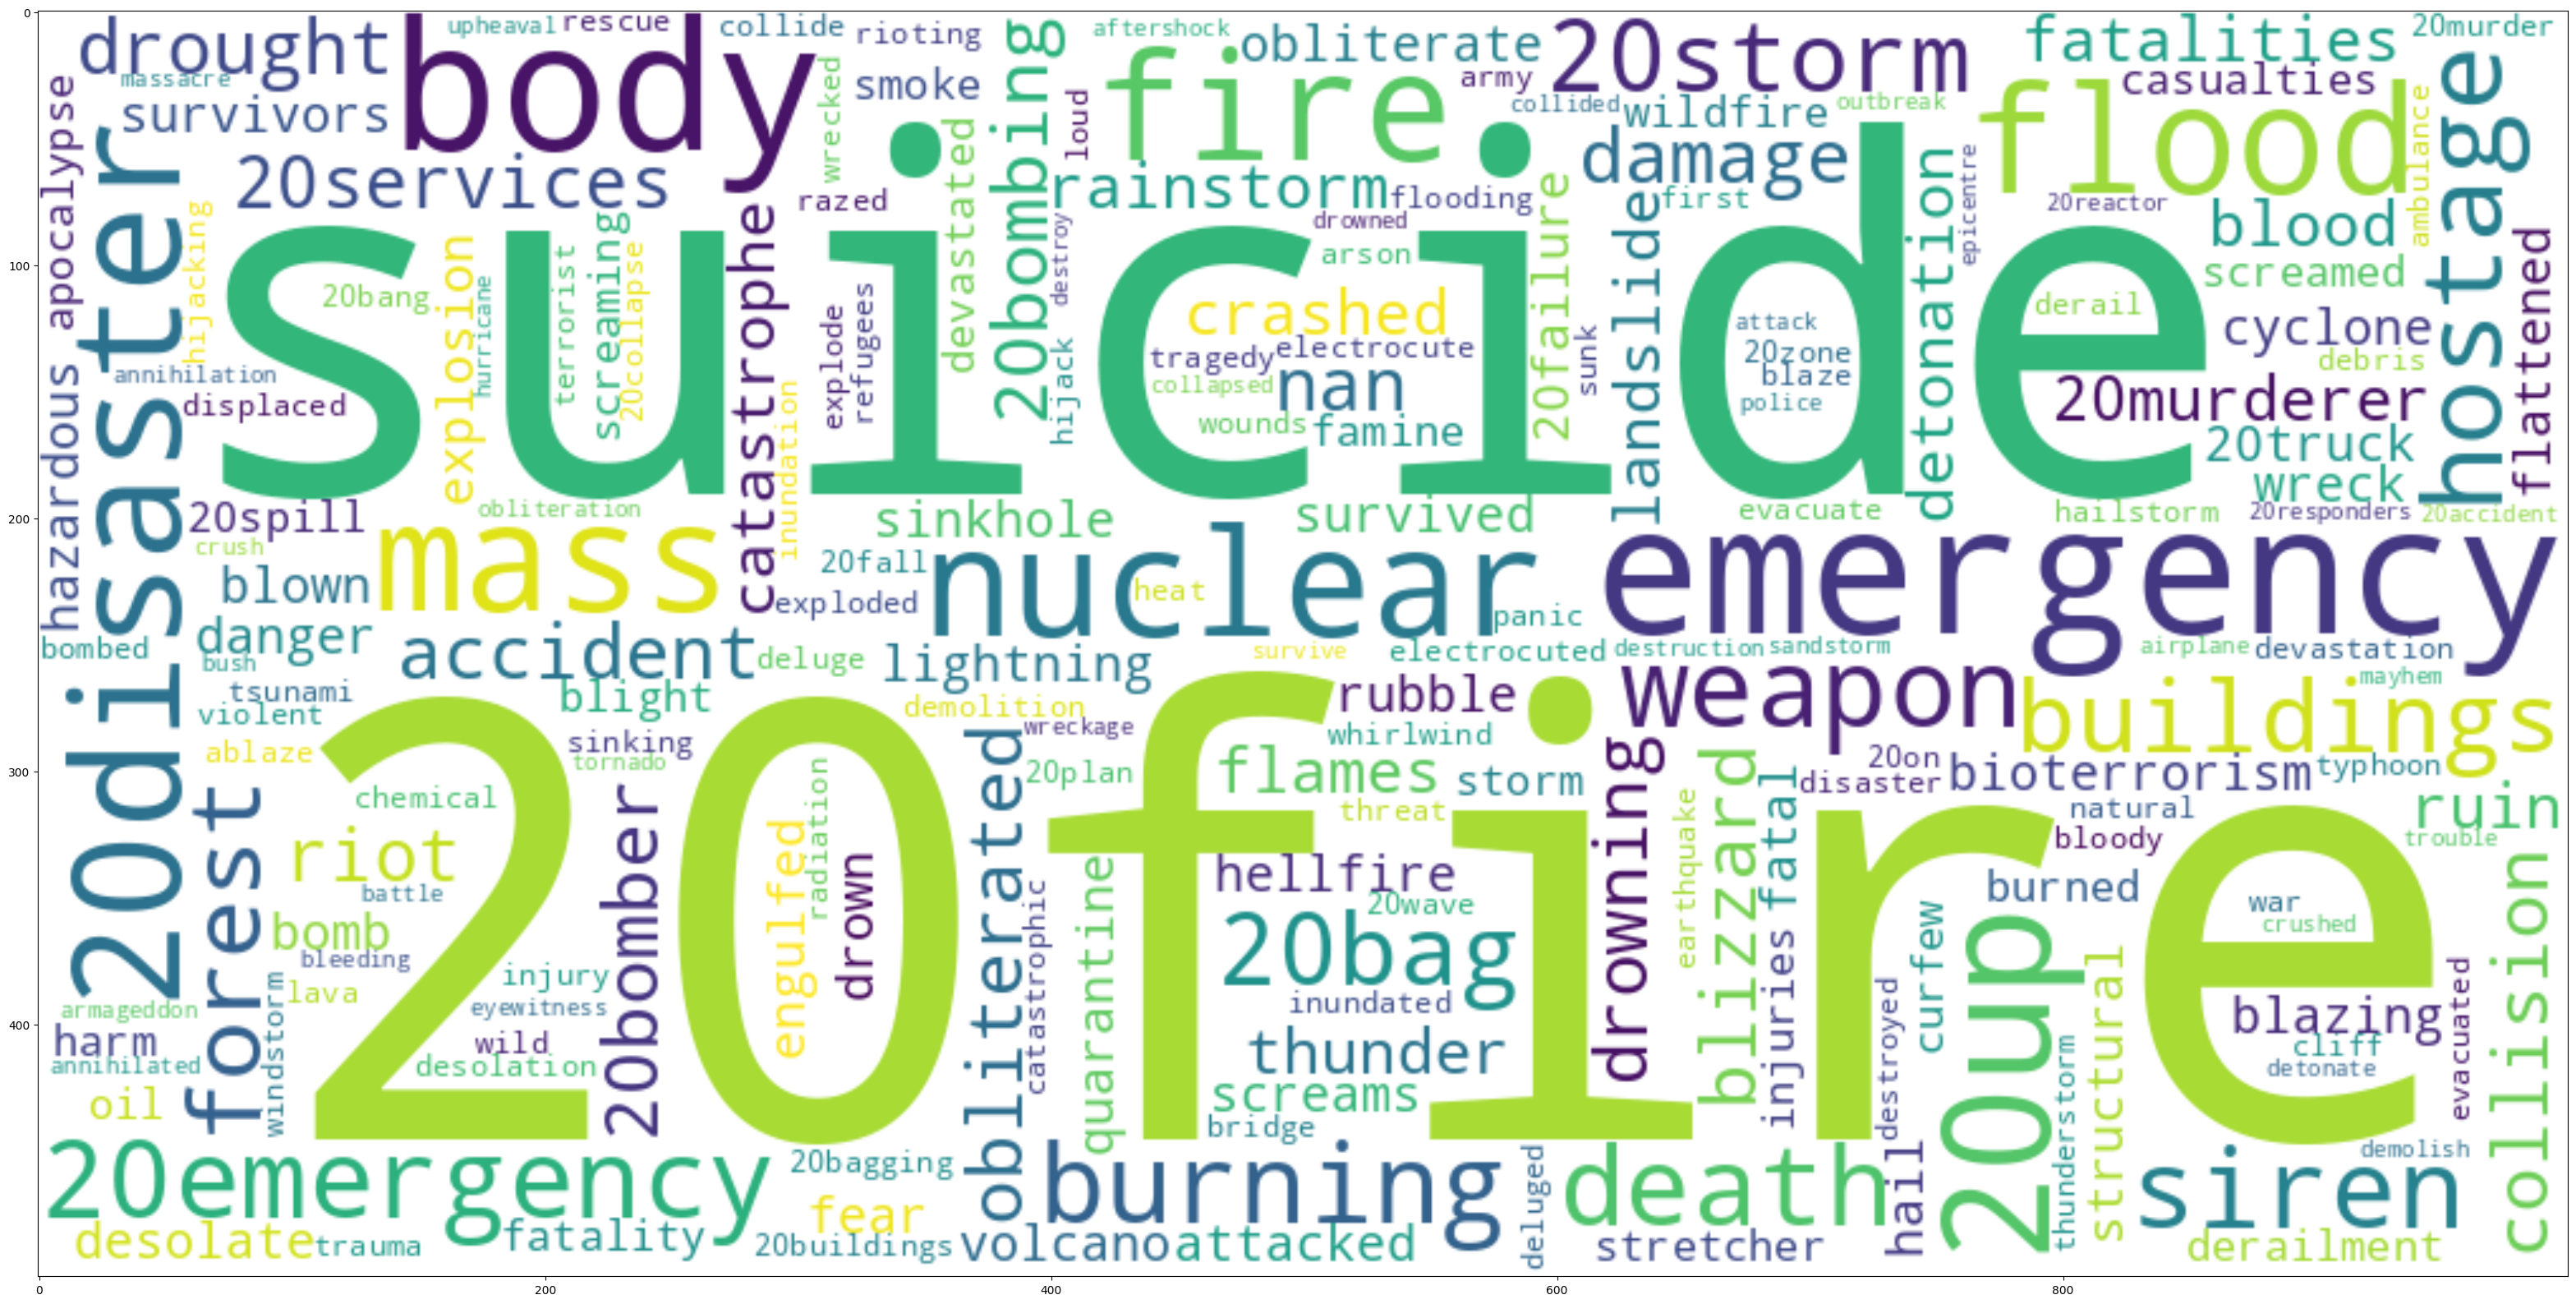

In [16]:
text = " ".join(set(word for word in clean_test['keyword'].astype(str)))
print(f"{len(set(text.split()))} unique words in the keyword column for Test data.")
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=1000, height=500).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [17]:
clean_train = clean_train.dropna(subset=['keyword']).reset_index(drop=True)

In [18]:
# we fill none into the Nan Values, to give 0 sentiment
clean_test['keyword'] = clean_test['keyword'].fillna("None")

In [19]:
clean_train

id  keyword  \
0        48   ablaze   
1        49   ablaze   
2        50   ablaze   
3        52   ablaze   
4        53   ablaze   
...     ...      ...   
7547  10830  wrecked   
7548  10831  wrecked   
7549  10832  wrecked   
7550  10833  wrecked   
7551  10834  wrecked   

                                                                                                             text  \
0                                                         @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C   
1                                             We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw   
2                              #AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi   
3                                                                              Crying out for more! Set me ablaze   
4                                    On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N   
...                                                                                                           ...   
7547                                                             @jt_ruff23 @cameronhacker and I wrecked you both   
7548  Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family for that one   
7549                #FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM   
7550     @engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO   
7551                             Cramer: Iger's 3 words that wrecked Disney's stock - CNBC http://t.co/N6RBnHMTD4   

      target  
0          1  
1          0  
2          1  
3          0  
4          0  
...      ...  
7547       0  
7548       0  
7549       0  
7550       0  
7551       0  

[7552 rows x 4 columns]

In [21]:
df_nondupes = clean_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)

In [22]:
df_nondupes = clean_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_nondupes.sample(2)

id  \
text                                                                                                                           
'Er indoors will be devastated. RIP Arfur. #GeorgeCole                                                                     1   
Firefighters from Connecticut are headed to California to fight wild fires http://t.co/QWpUxPyWbF http://t.co/8jlXZ6fkxy   1   

                                                                                                                          keyword  \
text                                                                                                                                
'Er indoors will be devastated. RIP Arfur. #GeorgeCole                                                                          1   
Firefighters from Connecticut are headed to California to fight wild fires http://t.co/QWpUxPyWbF http://t.co/8jlXZ6fkxy        1   

                                                                                                                          target  
text                                                                                                                              
'Er indoors will be devastated. RIP Arfur. #GeorgeCole                                                                         1  
Firefighters from Connecticut are headed to California to fight wild fires http://t.co/QWpUxPyWbF http://t.co/8jlXZ6fkxy       1

In [23]:
# check for duplicates using groupby
df_nondupes = clean_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_dupes = df_nondupes[df_nondupes['target'] > 1]
df_dupes.rename(columns={'id':'# of duplicates', 'target':'sum of target var'})

# of duplicates  \
text                                                                                                                                                           
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit                              2   
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife                                                       3   
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                                         6   
To fight bioterrorism sir.                                                                                                                                 4   
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                                6   
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!                                                     2   
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE                3   
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect                 3   
wowo--=== 12000 Nigerian refugees repatriated from Cameroon                                                                                                2   
RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG                                                             2   
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4                     4   
Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...                                                                       2   
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption                                      3   
CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring                                                                   3   
Caution: breathing may be hazardous to your health.                                                                                                        2   
I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????                                                                         2   
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time                          4   
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!                                         2   

                                                                                                                                             keyword  \
text                                                                                                                                                   
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit                      2   
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife                                               1   
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                                 1   
To fight bioterrorism sir.                                                                                                                         1   
He came to a land which was 

In [24]:
clean_train = clean_train.drop_duplicates(subset=['text'], keep='last').reset_index(drop=True)

In [25]:
clean_train.sample(2)

id     keyword  \
6880  10055     twister   
2452   3607  desolation   

                                                                                                                                            text  \
6880                                                 Some curls come out so pretty and some look like I just finished shooting the movie Twister   
2452  Just came back from camping and returned with a new song which gets recorded tomorrow. Can't wait! #Desolation #TheConspiracyTheory #NewEP   

      target  
6880       0  
2452       1

In [26]:
# we save these as pickles
clean_train.to_pickle("pickles/clean_train_data.pkl")
clean_test.to_pickle("pickles/clean_test_data.pkl")

In [27]:
# download pickles
train_df = pd.read_pickle("pickles/clean_train_data.pkl")
test_df = pd.read_pickle("pickles/clean_test_data.pkl")

In [28]:
def clean_text(text):
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    # remove unicode characters
    text =text.encode('ascii', 'ignore').decode()
    # Remove URLs
    text = re.sub(r'https*\S+', ' ', text)
    text = re.sub(r'http*\S+', ' ', text)
    
    return text

In [29]:

train_df['cleaned_text'] = train_df.text.apply(clean_text)
test_df['cleaned_text'] = test_df.text.apply(clean_text)

In [30]:
list(train_df['cleaned_text'].sample(20))


['contruction upgrading ferries to earthquake standards in vashon mukilteo q13 fox   earthquakenews',
 'so where are the rioters looters and burning buildings white lives matter',
 'trump will get absolutely demolished in a general election',
 'dnb newrelease edge jimmy summer rainstorm lapaka sounds   via  ',
 'the possible new jerseys for the avalanche next year  ',
 'radiation emergency preparedness starts with knowing to get inside stay inside and stay tuned   via',
 'poor liv and i getting our phones wrecked on the same day thatswhatfriendsarefor',
 'potus strategicpatience is a strategy for genocide refugees idp internally displaced people horror etc  ',
 'families to sue over legionnaires more than 40 families affected by the fatal outbreak o   news check follow',
 'mh370 aircraft debris found on la reunion is from missing malaysia airlines abc online  ',
 'now trending in nigeria police charge traditional ruler others with informants murder  ',
 'possibly hes had injuries on bo

In [31]:
# create final dfs without text col
final_train_df = train_df.drop(columns=['text', 'id'])
final_test_df = test_df.drop(columns=['text', 'id'])

# save labels
train_labels = final_train_df['target']

# separate clean text
train_text = final_train_df['cleaned_text']
test_text = final_test_df['cleaned_text']

In [32]:
# we use a pre-trained bert model to tokenize the text
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [33]:
token_lens = []
for txt in list(train_text):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

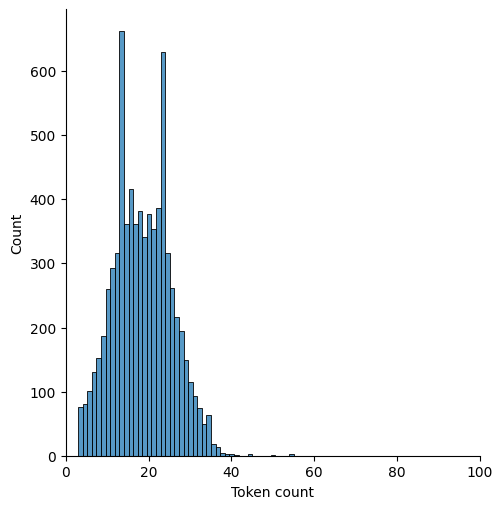

In [36]:
sns.displot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')
plt.show()

In [37]:
def bert_tokenizer(text):
    encoding = tokenizer.encode_plus(
    text,
    max_length=55,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
    )
    return encoding['input_ids'][0], encoding['attention_mask'][0]

In [38]:
max_length=55
# train data tokenization
train_tokenized_list = []
train_attn_mask_list = []
for text in list(train_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    train_tokenized_list.append(tokenized_text.numpy())
    train_attn_mask_list.append(attn_mask.numpy())

In [39]:
# test data tokenization
test_tokenized_list = []
test_attn_mask_list = []
for text in list(test_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    test_tokenized_list.append(tokenized_text.numpy())
    test_attn_mask_list.append(attn_mask.numpy())

In [40]:
train_tokenised_text_df = pd.DataFrame(train_tokenized_list)
test_tokenised_text_df = pd.DataFrame(test_tokenized_list)

In [42]:
X_train, X_test, y_train, y_test, train_mask, test_mask = train_test_split(train_tokenised_text_df, train_labels, train_attn_mask_list, test_size=0.3, random_state=42)

In [43]:
print(f'X_train input shape {X_train.shape} X_test input shape {X_test.shape}\nTrain label \
shape {y_train.shape} Test label shape {y_test.shape}')

X_train input shape (5212, 55) X_test input shape (2235, 55)
Train label shape (5212,) Test label shape (2235,)


In [44]:
num_classes = len(train_labels.unique())


In [49]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

checkpoint_path = "../models/light_tf_bert.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

print('\nBert Model', bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [50]:
history=bert_model.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=2,
                       validation_data=(X_test, y_test),
                       callbacks=[model_callback])

Epoch 1/2
163/163 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.7713
Epoch 1: saving model to ../models/light_tf_bert.ckpt
163/163 [==============================] - 928s 6s/step - loss: 0.4890 - accuracy: 0.7713 - val_loss: 0.4356 - val_accuracy: 0.8085
Epoch 2/2
163/163 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8548
Epoch 2: saving model to ../models/light_tf_bert.ckpt
163/163 [==============================] - 963s 6s/step - loss: 0.3638 - accuracy: 0.8548 - val_loss: 0.4150 - val_accuracy: 0.8336


In [ ]:
# checkpoint_path = "../models/light_tf_bert.ckpt"
# trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
# trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [51]:
test_pred = bert_model.predict(X_test)
print(test_pred)

70/70 [==============================] - 96s 1s/step
TFSequenceClassifierOutput(loss=None, logits=array([[ 0.23138005, -0.9692189 ],
       [-2.2578669 ,  1.3775111 ],
       [-2.185058  ,  1.261258  ],
       ...,
       [-1.5835105 ,  0.2416105 ],
       [ 1.4172198 , -1.5870942 ],
       [ 0.16271955, -0.8163428 ]], dtype=float32), hidden_states=None, attentions=None)


In [54]:
# use softmax on logits
tensor_test_predictions = tf.math.softmax(test_pred.logits, axis=1)
print(tensor_test_predictions)

tf.Tensor(
[[0.7686313  0.23136866]
 [0.02569625 0.97430366]
 [0.03087891 0.9691212 ]
 ...
 [0.13882051 0.8611795 ]
 [0.9527687  0.04723136]
 [0.72692215 0.2730779 ]], shape=(2235, 2), dtype=float32)


In [56]:
# then use argmax after softmax to turn into labels
test_predictions = [list(bert_model.config.id2label.keys())[i] for i in tf.math.argmax(tensor_test_predictions, axis=1).numpy()]


In [57]:
# model test function
def eval_model(predictions):
    print(accuracy_score(y_test, predictions))
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(np.array(y_test), np.array(predictions))
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print(classification_report(y_test, np.array(predictions), target_names=["not disaster", "disaster"]))

In [58]:
eval_model(test_predictions)

NameError: name 'accuracy_score' is not defined